# Configuration and Filepaths

In [1]:
!pip install -q PyWavelets

import pywt
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import glob
import os

print("PyWavelets installed and libraries imported.")

PyWavelets installed and libraries imported.


In [3]:
def hjorth_params(x):
    """Calculate Hjorth parameters: Activity, Mobility, Complexity."""
    # Activity
    activity = np.var(x)
    
    # Mobility
    diff_x = np.diff(x)
    var_diff_x = np.var(diff_x)
    if activity == 0:
        mobility = 0
    else:
        mobility = np.sqrt(var_diff_x / activity)
        
    # Complexity
    diff_diff_x = np.diff(diff_x)
    var_diff_diff_x = np.var(diff_diff_x)
    if mobility == 0 or var_diff_x == 0:
        complexity = 0
    else:
        mobility_diff = np.sqrt(var_diff_diff_x / var_diff_x)
        complexity = mobility_diff / mobility
        
    return activity, mobility, complexity

def extract_features(epoch):
    """
    Extracts statistical and Hjorth features from an EEG epoch using SWT.
    
    Args:
        epoch (numpy.ndarray): Shape (n_channels, n_samples). 
                               Expected n_samples=500 initially.
    
    Returns:
        numpy.ndarray: Flattened feature vector.
    """
    n_channels, n_samples = epoch.shape
    
    # 1. Zero-padding to 512 samples
    target_length = 512
    if n_samples < target_length:
        pad_width = target_length - n_samples
        # Pad last dimension (time)
        epoch_padded = np.pad(epoch, ((0, 0), (0, pad_width)), mode='constant')
    else:
        epoch_padded = epoch[:, :target_length]

    # 2. SWT Decomposition
    # axis=-1 is default, which is time here
    # trim_approx=False keeps all coefficients
    coeffs = pywt.swt(epoch_padded, wavelet='db4', level=4, trim_approx=False)
    # coeffs structure from pywt.swt is a list of tuples: [(cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1)]
    
    feature_vector = []
    
    # Iterate by channel to keep structure consistent
    for ch in range(n_channels):
        # Extract this channel's data from all coefficients
        # coeffs[level_index][type_index][channel_index, time_index]
        
        # Flatten the list of tuples into a sequence of subbands for this channel
        # Order: cA4, cD4, cA3, cD3, cA2, cD2, cA1, cD1
        channel_coeffs = []
        for (cA, cD) in coeffs:
            channel_coeffs.append(cA[ch])
            channel_coeffs.append(cD[ch])
        
        for c in channel_coeffs:
            # Statistical Features
            mean_val = np.mean(c)
            std_val = np.std(c)
            skew_val = skew(c)
            kurt_val = kurtosis(c)
            
            # Hjorth Parameters
            act, mob, comp = hjorth_params(c)
            
            feature_vector.extend([mean_val, std_val, skew_val, kurt_val, act, mob, comp])
            
    return np.array(feature_vector)

# --- Main Execution Loop ---

# Ensure OUTPUT_DIR is defined (from previous context)
if 'OUTPUT_DIR' not in locals():
    from pathlib import Path
    OUTPUT_DIR = Path("F:\Rice\Rice F25\Seizure Project\Processed_Gemini_V3")

all_features = []
all_labels = []

npz_files = sorted(list(OUTPUT_DIR.glob("*.npz")))
print(f"Found {len(npz_files)} files for feature extraction.")

# Process each file
for f in npz_files:
    try:
        data = np.load(f)
        X = data['X_teacher'] # Shape: (n_windows, n_channels, n_samples)
        y = data['y']         # Shape: (n_windows,)
        
        # Iterate through windows in the file
        for i in range(len(X)):
            feat = extract_features(X[i])
            all_features.append(feat)
            all_labels.append(y[i])
            
    except Exception as e:
        print(f"Error processing {f.name}: {e}")

# Convert to numpy arrays
X_features = np.array(all_features)
y_labels = np.array(all_labels)

print("="*30)
print("Feature Extraction Complete")
print(f"X_features shape: {X_features.shape}")
print(f"y_labels shape: {y_labels.shape}")

Found 317 files for feature extraction.
Feature Extraction Complete
X_features shape: (139781, 112)
y_labels shape: (139781,)


# Support Vector Machine

In [4]:
from tqdm.notebook import tqdm
import numpy as np

all_wear_features_list = []
feature_lengths = []

# Ensure we use the exact same file order as the EEG extraction
npz_files = sorted(list(OUTPUT_DIR.glob("*.npz")))
print(f"Processing {len(npz_files)} files for Wearable feature extraction...")

for f in tqdm(npz_files, desc="Extracting Wearable Features"):
    try:
        data = np.load(f)
        X_stu = data['X_student']  # Shape: (n_windows, n_channels, n_samples)

        # Iterate through windows in the file
        for i in range(len(X_stu)):
            # Reuse the existing extract_features function
            feat = extract_features(X_stu[i])
            all_wear_features_list.append(feat)
            feature_lengths.append(len(feat))

    except Exception as e:
        print(f"Error processing {f.name}: {e}")

# --- Fix for Inhomogeneous Shapes ---
if len(feature_lengths) > 0:
    # Find the most common length (mode)
    vals, counts = np.unique(feature_lengths, return_counts=True)
    mode_len = vals[np.argmax(counts)]
    print(f"Most common feature vector length: {mode_len}")

    # Identify mismatches
    lengths_arr = np.array(feature_lengths)
    mismatch_mask = lengths_arr != mode_len
    n_mismatch = np.sum(mismatch_mask)

    if n_mismatch > 0:
        print(f"WARNING: Found {n_mismatch} samples with inconsistent feature lengths. Dropping them to ensure array homogeneity.")
        
        # Filter the wearable list
        # (Using list comprehension for the list of arrays)
        all_wear_features_list = [f for f, l in zip(all_wear_features_list, feature_lengths) if l == mode_len]
        
        # Check if we need to align X_features (EEG) and y_labels
        if 'X_features' in locals() and 'y_labels' in locals():
            if len(X_features) == len(lengths_arr):
                print("Aligning X_features (EEG) and y_labels with the filtered wearable data...")
                keep_mask = ~mismatch_mask
                X_features = X_features[keep_mask]
                y_labels = y_labels[keep_mask]
                print(f"New shapes -> EEG: {X_features.shape}, Labels: {y_labels.shape}")
            else:
                print(f"CRITICAL: EEG features count ({len(X_features)}) != Wearable count ({len(lengths_arr)}). Automatic alignment failed. Please check file processing order.")

    # Now safe to convert
    X_wear_features = np.array(all_wear_features_list)

    print("="*30)
    print("Wearable Feature Extraction Complete")
    print(f"X_wear_features shape: {X_wear_features.shape}")

    # Final Sanity Check
    if 'X_features' in locals():
        print(f"Alignment Check: EEG samples {X_features.shape[0]} vs Wearable samples {X_wear_features.shape[0]}")
        assert X_features.shape[0] == X_wear_features.shape[0], "Mismatch in sample counts!"
else:
    print("No features were extracted. Check input files.")

Processing 317 files for Wearable feature extraction...


Extracting Wearable Features:   0%|          | 0/317 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
import numpy as np
from pathlib import Path

BASE_DIR = Path("F:\Rice\Rice F25\Seizure Project\Features")
FEATURE_FILE = BASE_DIR / "features_v3_full.npz"

data = np.load(FEATURE_FILE)
X_features = data['X_eeg']
X_wear_features = data['X_wear']
y_labels = data['y']

print("Features loaded successfully!")

Features loaded successfully!


Combining all features (EEG + Wearable)...
Full Feature Shape: (125288, 896)

Training SVM (RBF) on ALL 896 features...
[LibSVM]Training Complete. Time taken: 65.39 minutes.
Predicting...


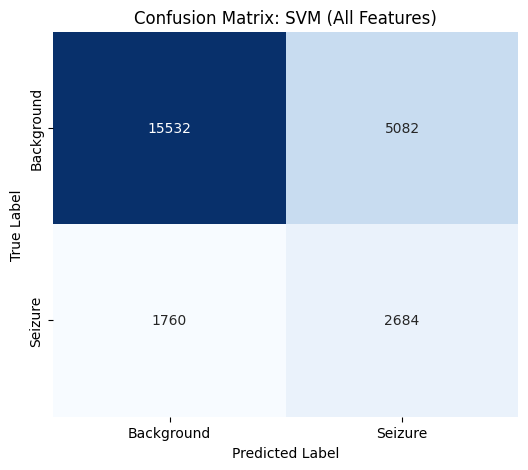


Classification Report:
              precision    recall  f1-score   support

  Background       0.90      0.75      0.82     20614
     Seizure       0.35      0.60      0.44      4444

    accuracy                           0.73     25058
   macro avg       0.62      0.68      0.63     25058
weighted avg       0.80      0.73      0.75     25058



In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

# 1. Prepare Full Dataset
if 'X_features' in locals() and 'X_wear_features' in locals():
    print("Combining all features (EEG + Wearable)...")
    X_full = np.concatenate([X_features, X_wear_features], axis=1)
    print(f"Full Feature Shape: {X_full.shape}")
    
    # Split Data (80/20)
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X_full, y_labels, test_size=0.2, random_state=42, stratify=y_labels
    )
else:
    print("Error: Base feature arrays (X_features, X_wear_features) not found. Please run extraction/loading first.")

# 2. Initialize SVM
print(f"\nTraining SVM (RBF) on ALL {X_train_full.shape[1]} features...")
svm_full = SVC(
    kernel='rbf',
    class_weight='balanced',
    cache_size=2000,
    random_state=42,
    verbose=True
)

# 3. Train
start_time = time.time()
svm_full.fit(X_train_full, y_train_full)
end_time = time.time()
print(f"Training Complete. Time taken: {(end_time - start_time)/60:.2f} minutes.")

# 4. Evaluate
print("Predicting...")
y_pred_full = svm_full.predict(X_test_full)

# Visualization
cm = confusion_matrix(y_test_full, y_pred_full)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: SVM (All Features)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_full, target_names=['Background', 'Seizure']))

In [21]:
# Using the new modality-specific feature sets for baseline models

import numpy as np
from pathlib import Path

BASE_DIR = Path("F:\Rice\Rice F25\Seizure Project\Features")
FEATURE_FILE = BASE_DIR / "expanded_features.npz"

data = np.load(FEATURE_FILE)
X_features = data['X_expanded']
y_labels = data['y_expanded']

print("Features loaded successfully!")

Features loaded successfully!


Data is clean (No NaNs/Infs).
Combining all features (EEG + Wearable)...
Full Feature Shape: (139781, 367)
Class Weights computed: {0: np.float64(0.6070990368850234), 1: np.float64(2.8342880316317736)}

Training SVM (RBF) on ALL 367 features...
[LibSVM]Training Complete. Time taken: 33.03 minutes.
Predicting...


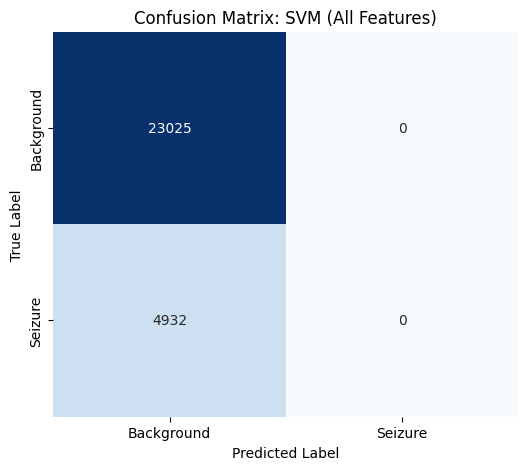


Classification Report:
              precision    recall  f1-score   support

  Background       0.82      1.00      0.90     23025
     Seizure       0.00      0.00      0.00      4932

    accuracy                           0.82     27957
   macro avg       0.41      0.50      0.45     27957
weighted avg       0.68      0.82      0.74     27957



c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [23]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.utils.class_weight import compute_class_weight




# --- FIX: Handle Infs and NaNs ---
# 1. Replace Infinity with NaN
if np.isinf(X_features).any():
    print("Infinite values detected in feature matrix. Replacing with NaN...")
    X_features[np.isinf(X_features)] = np.nan

# 2. Impute NaNs
if np.isnan(X_features).any():
    print("NaNs detected. Imputing with mean values...")
    imputer = SimpleImputer(strategy='mean')
    X_features = imputer.fit_transform(X_features)
    print("Imputation complete.")
else:
    print("Data is clean (No NaNs/Infs).")
# ---------------------------------



# 1. Prepare Full Dataset
if 'X_features' in locals() and 'X_wear_features' in locals():
    print("Combining all features (EEG + Wearable)...")
    print(f"Full Feature Shape: {X_features.shape}")
    
    # Split Data (80/20)
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
    )
else:
    print("Error: Base feature arrays (X_features, X_wear_features) not found. Please run extraction/loading first.")
    
    
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights computed: {class_weight_dict}")

# 2. Initialize SVM
print(f"\nTraining SVM (RBF) on ALL {X_train_full.shape[1]} features...")
svm_full = SVC(
    kernel='rbf',
    class_weight=class_weight_dict,
    cache_size=2000,
    random_state=42,
    verbose=True
)

# 3. Train
start_time = time.time()
svm_full.fit(X_train_full, y_train_full)
end_time = time.time()
print(f"Training Complete. Time taken: {(end_time - start_time)/60:.2f} minutes.")

# 4. Evaluate
print("Predicting...")
y_pred_full = svm_full.predict(X_test_full)

# Visualization
cm = confusion_matrix(y_test_full, y_pred_full)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: SVM (All Features)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_full, target_names=['Background', 'Seizure']))

In [2]:
# Using the new modality-specific feature sets for baseline models

import numpy as np
from pathlib import Path

BASE_DIR = Path("F:\Rice\Rice F25\Seizure Project\Features")
FEATURE_FILE = BASE_DIR / "lightweight_features.npz"

data = np.load(FEATURE_FILE)
X_features = data['X']
y_labels = data['y']

print("Features loaded successfully!")

Features loaded successfully!


# Chrononet CNN+RNN

In [7]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# 1. Define Path
DATA_DIR = Path("F:\Rice\Rice F25\Seizure Project\Processed_Gemini_V3")

# 2. Load Data
print("Loading data for ChronoNet...")
npz_files = sorted(list(DATA_DIR.glob("*.npz")))

X_list = []
y_list = []

for f in tqdm(npz_files, desc="Loading files"):
    try:
        data = np.load(f)
        # X_teacher shape is (n_windows, n_channels, n_samples)
        X_list.append(data['X_teacher'])
        y_list.append(data['y'])
    except Exception as e:
        print(f"Error loading {f.name}: {e}")

# 3. Concatenate
X_full = np.concatenate(X_list, axis=0)
y_full = np.concatenate(y_list, axis=0)

print(f"Original Shape: {X_full.shape}")

# 4. Reshape for Keras (Batch, Time, Channels)
# Current: (Batch, Channels, Time) -> Target: (Batch, Time, Channels)
X_full = np.transpose(X_full, (0, 2, 1))

print(f"Reshaped for Keras: {X_full.shape}")

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print("="*30)
print("Data Loading Complete")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

Loading data for ChronoNet...


Loading files:   0%|          | 0/317 [00:00<?, ?it/s]

Original Shape: (139781, 2, 500)
Reshaped for Keras: (139781, 500, 2)
Data Loading Complete
X_train shape: (111824, 500, 2)
y_train shape: (111824,)
X_test shape:  (27957, 500, 2)
y_test shape:  (27957,)


Class Weights: {np.int8(0): np.float64(0.6070990368850234), np.int8(1): np.float64(2.8342880316317736)}


Model: "ChronoNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 500, 2)    │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 32)   │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 32)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 500, 32)   │        352 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 500, 32)   │         96 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 500, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 500, 128)  │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 250, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 250, 128)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 250, 128)  │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 250, 32)   │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 250, 32)   │     12,320 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 250, 32)   │     20,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 250, 32)   │      4,128 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 250, 128)  │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 128)  │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 125, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 161,345 (630.25 KB)

 Trainable params: 160,321 (626.25 KB)

 Non-trainable params: 1,024 (4.00 KB)

None

Starting ChronoNet Training...
Epoch 1/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 110s 38ms/step - accuracy: 0.6291 - loss: 0.6711 - val_accuracy: 0.7073 - val_loss: 0.6500
Epoch 2/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 114s 41ms/step - accuracy: 0.7078 - loss: 0.6423 - val_accuracy: 0.7429 - val_loss: 0.6066
Epoch 3/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 115s 41ms/step - accuracy: 0.7235 - loss: 0.6252 - val_accuracy: 0.7768 - val_loss: 0.5565
Epoch 4/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 111s 40ms/step - accuracy: 0.7181 - loss: 0.6189 - val_accuracy: 0.7902 - val_loss: 0.5604
Epoch 5/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 112s 40ms/step - accuracy: 0.7314 - loss: 0.6064 - val_accuracy: 0.7903 - val_loss: 0.5302
Epoch 6/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 111s 40ms/step - accuracy: 0.7379 - loss: 0.5985 - val_accuracy: 0.7613 - val_loss: 0.5529
Epoch 7/30
2796/2796 ━━━━━━━━━━━━━━━━━━━━ 110s 39ms/step - accuracy: 0.7403 - loss: 0.5953 - val_accuracy: 0.7192 - val_loss: 0.6021
Epoch 8/30
2796/2796 ━━━━━━━━━━━

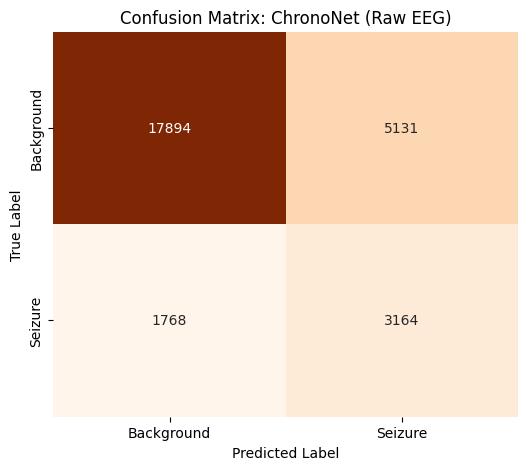


Classification Report:
              precision    recall  f1-score   support

  Background       0.91      0.78      0.84     23025
     Seizure       0.38      0.64      0.48      4932

    accuracy                           0.75     27957
   macro avg       0.65      0.71      0.66     27957
weighted avg       0.82      0.75      0.77     27957



In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, GRU, Dense, Dropout, BatchNormalization, Activation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Compute Class Weights ---
# (Crucial given the small/imbalanced dataset loaded)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))
print(f"Class Weights: {class_weight_dict}")

# --- 2. Define ChronoNet Architecture ---
def inception_block(input_tensor, filters=32, stride=1, activation='relu'):
    # Branch 1: 1x1 Conv
    branch1 = Conv1D(filters, 1, strides=stride, padding='same', activation=activation)(input_tensor)
    
    # Branch 2: 3x3 Conv
    branch2 = Conv1D(filters, 3, strides=stride, padding='same', activation=activation)(input_tensor)
    
    # Branch 3: 5x5 Conv
    branch3 = Conv1D(filters, 5, strides=stride, padding='same', activation=activation)(input_tensor)
    
    # Branch 4: MaxPool + 1x1 Conv
    branch4 = MaxPooling1D(3, strides=stride, padding='same')(input_tensor)
    branch4 = Conv1D(filters, 1, padding='same', activation=activation)(branch4)
    
    # Concatenate
    x = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    x = BatchNormalization()(x)
    return x

def build_chrononet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Feature Extraction (Inception Blocks)
    x = inception_block(inputs, filters=32)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)
    
    x = inception_block(x, filters=32)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)
    
    x = inception_block(x, filters=64)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)
    
    # Temporal Modeling (GRU)
    # Return sequences=True for stacked GRUs
    x = GRU(32, return_sequences=True)(x)
    x = GRU(32)(x)
    x = Dropout(0.3)(x)
    
    # Classification
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs, name='ChronoNet')
    return model

# --- 3. Build & Compile ---
input_shape = (X_train.shape[1], X_train.shape[2]) # (500, 2)
model_chrono = build_chrononet(input_shape)

model_chrono.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

print(model_chrono.summary())

# --- 4. Train ---
print("\nStarting ChronoNet Training...")
history_chrono = model_chrono.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30, 
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

# --- 5. Evaluate ---
print("\nEvaluating on Test Set...")
y_pred_prob = model_chrono.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# --- 6. Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: ChronoNet (Raw EEG)')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Background', 'Seizure'], zero_division=0))

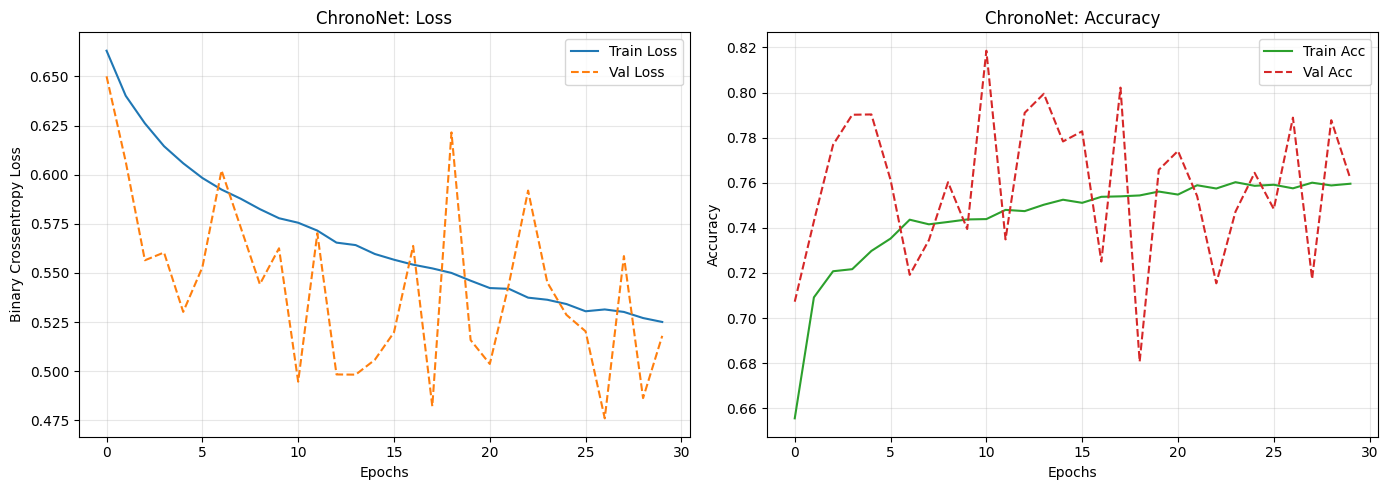

In [9]:
import matplotlib.pyplot as plt

# Check if history exists
if 'history_chrono' in locals():
    history = history_chrono
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='tab:orange', linestyle='--')
    ax[0].set_title('ChronoNet: Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Binary Crossentropy Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Accuracy
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='tab:green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='tab:red', linestyle='--')
    ax[1].set_title('ChronoNet: Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("History object 'history_chrono' not found. Make sure the training step completed successfully.")